<a href="https://colab.research.google.com/github/EbnAbona/AI-For-Music-Not-Impossible/blob/latest/SeniorDesignCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import time
from fastprogress import master_bar, progress_bar
from torchvision.models import resnet18
from datetime import timedelta

In [ ]:
class MyDataSet(Dataset):
  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      self.X = torch.from_numpy(X).float()
      self.y = torch.from_numpy(y).float()
    
  def __len__(self):
    return len(self.X) - 40

  def __getitem__(self, i):
    return np.expand_dims(self.X[i: i+40,:], 0), self.y[i+40]

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.Dropout(0.5),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2))
        self.embeddings = nn.Sequential(
            nn.Linear(65536, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 48)
            # nn.Linear(128, 48),
            #nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x).permute(0, 2, 3, 1).contiguous()
        x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        x = self.embeddings(x)
        return x

In [ ]:
def getSpectrograms2():
  allMidi_X = np.load('/content/drive/MyDrive/Senior_Design/MIDI/final_input.npy')
  return allMidi_X

In [ ]:
def plotData(data, original, title):
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()
  plt.plot(original.cpu().detach().numpy(), label = "Original")
  plt.title(f'{title} - Original')
  plt.show()
  plt.plot(data.cpu().detach().numpy(), label = "Predicted")
  plt.title(f'{title} - Predicted')
  plt.show()

In [ ]:
def getSets2(allMidi_X):
  allMidi_Y = np.load('/content/drive/MyDrive/Senior_Design/MIDI/final_output.npy').T
  newMidi_X = np.log10(np.abs(allMidi_X)+1e-15).T
  return newMidi_X, allMidi_Y

In [ ]:
def buildDatasets(train_X, train_Y, test_X, test_Y):
  dataset_train = MyDataSet(train_X,train_Y)
  dataset_test = MyDataSet(test_X,test_Y)
  return dataset_train, dataset_test

In [ ]:
def saveCheckpoint(EPOCH, model_state_dict, optimizer_state_dict, LOSS):
  torch.save({
            'epoch': EPOCH,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'loss': LOSS,
            }, '/content/drive/MyDrive/Senior_Design/latestCheckpoint.pt')

In [ ]:
def trainModel(dataset_train, dataset_val, num_epochs=40, batch_size=40, loadCheckPoint=False, saveModel=True, saveCheckpoints=True, plotResults=True, pretrained=False):
  lr = 1e-4
  patience=35

  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True,)
  model = ConvNet().cuda()
  if pretrained==True:
    model = resnet18(pretrained=True).cuda()
    model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                          kernel_size=model.conv1.kernel_size[0], 
                          stride=model.conv1.stride[0], 
                          padding=model.conv1.padding[0]).cuda()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 48).cuda()
  loss_function = nn.L1Loss().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                               mode='min',
                                               factor=0.5,
                                               patience=35,
                                               verbose=True)

  best_loss = 0.0
  last_loss = 0.0
  val_loss = 0.0
  k_patience = 0
  best_val = np.Inf
  final_start_time = time.time()
  
  if loadCheckPoint == True:
    checkpoint = torch.load('/content/drive/MyDrive/Senior_Design/latestCheckpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']

  # Run the training loop
  mb = master_bar(range(num_epochs))
  for epoch in mb:
    start_time = time.time()

    # Set current loss value
    current_loss = 0.0
    i = 0
    # Iterate over the DataLoader for training data
    for data in progress_bar(train_loader, parent=mb):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = model(inputs.cuda())
      
      # Compute loss
      loss = loss_function(outputs, targets.cuda())
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      last_loss = current_loss / len(train_loader)
      if i % 1000 == 0:
        elapsed = time.time() - start_time
        mb.write(f'Epoch {epoch+1} - Loss after mini-batch {(i + 1):5d}: {(current_loss / len(train_loader)):.8f} - Time: {elapsed:.0f}s')
        current_loss = 0.0
      i = i + 1

    if epoch % 5 == 0 and plotResults == True:
      plotData(outputs, targets, f"Epoch {epoch+1} - Training")

    i = 0
    # Set current loss value
    current_loss = 0.0
    for data in progress_bar(val_loader, parent=mb):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      
      # Perform forward pass
      outputs = model(inputs.cuda())
      
      # Compute loss
      loss = loss_function(outputs, targets.cuda())
      
      # Print statistics
      current_loss += loss.item()
      val_loss = current_loss / len(val_loader)
      if i % 1000 == 0:
        elapsed = time.time() - start_time
        mb.write(f'Epoch {epoch+1} - VALLoss after mini-batch {(i + 1):5d}: {val_loss:.8f} - Time: {elapsed:.0f}s')
        current_loss = 0.0
      i = i + 1

    if last_loss > best_loss and saveCheckpoints == True and i > 1:
      saveCheckpoint(epoch, model.state_dict(), optimizer.state_dict(), last_loss)
      best_loss = last_loss

    if epoch % 5 == 0 and plotResults == True:
      plotData(outputs, targets, f"Epoch {epoch+1} - Validation")

    scheduler.step(val_loss)
    # check if val loss has been improving during patience period. If not, stop
    is_val_improving = scheduler.is_better(val_loss, best_val)
    if not is_val_improving:
        k_patience += 1
    else:
        k_patience = 0
    if k_patience > patience * 3:
        # Increase patience since adaptive learning rate is changed AFTER this step
        print("Early Stopping")
        break

    best_val = scheduler.best
    lr = optimizer.param_groups[0]['lr']
  if saveModel == True:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Senior_Design/finalTrainedModel.pt')
  print("Training took: ", timedelta(seconds=time.time() - final_start_time))
  return model

In [ ]:
def predictModel(test_dataset):
  batch_size = 64
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  model= ConvNet()
  model.load_state_dict(torch.load('/content/drive/MyDrive/Senior_Design/finalTrainedModel.pt', map_location=torch.device('cpu')))
  model = model.cuda()

  all_outputs = []
  pb = progress_bar(test_loader)
  i = 0
  for data in pb:
    # Get and prepare inputs
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    
    # Perform forward pass
    outputs = model(inputs.cuda())
    if i == 0:
      all_outputs = outputs.cpu().detach().numpy()
    else:
      all_outputs = np.concatenate((all_outputs, outputs.cpu().detach().numpy()), axis=0)
    i+=1
  return all_outputs

In [ ]:
allMidi_X = getSpectrograms2()

In [ ]:
midi_X, midi_Y = getSets2(allMidi_X)

In [ ]:
midi_X.shape, midi_Y.shape

((188980, 1025), (188980, 48))

In [ ]:
dataset_train, dataset_test = buildDatasets(midi_X[:-50000], midi_Y[:-50000], midi_X[-50000:-25000], midi_Y[-50000:-25000])
dataset_train, dataset_val = buildDatasets(midi_X[:-50000], midi_Y[:-50000], midi_X[-25000:], midi_Y[-25000:])

2 Hours and 10 minutes of training on GPU

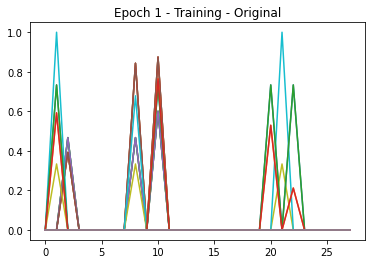

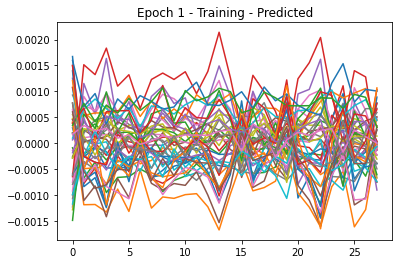

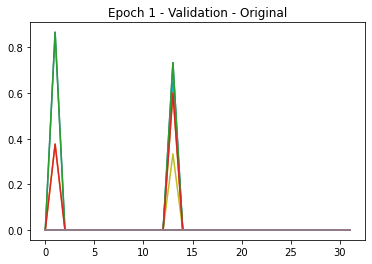

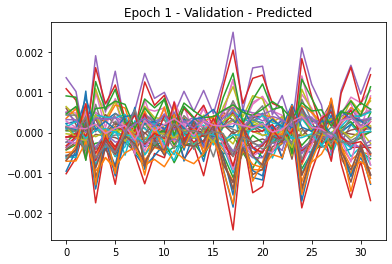

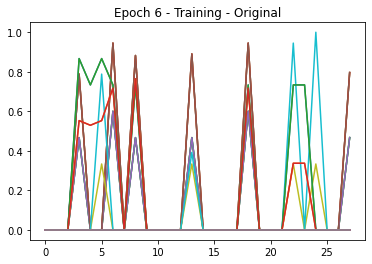

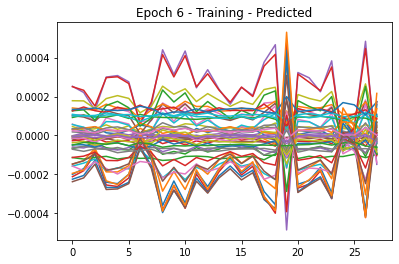

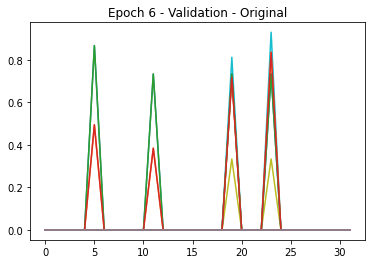

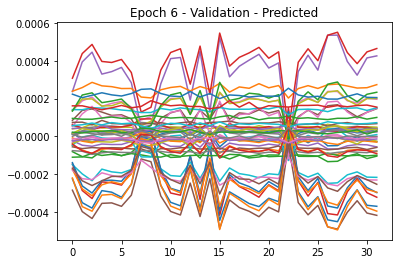

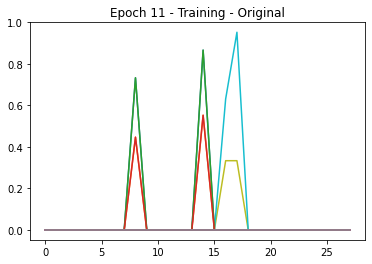

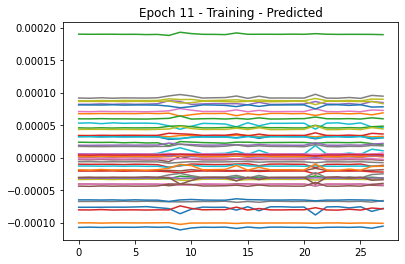

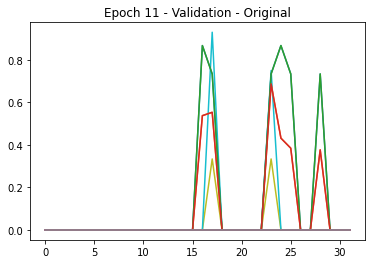

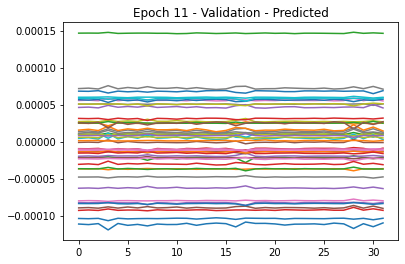

In [ ]:
from torchsummary import summary
model = trainModel(dataset_train=dataset_train, dataset_val=dataset_val,
                   num_epochs=30, 
                   batch_size=32, 
                   loadCheckPoint=False, 
                   saveModel=True, #True, 
                   saveCheckpoints=True, #True, 
                   plotResults=True, 
                   pretrained=False)

7 Minutes on predicting on CPU

In [ ]:
prediction = predictModel(dataset_test)

In [ ]:
prediction.shape

(24960, 48)

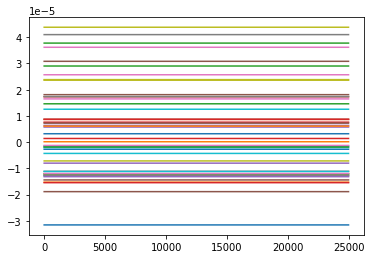

In [ ]:
b = range(1, 48,1)
_ = plt.plot(prediction[:, b])

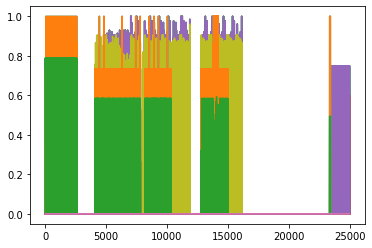

In [ ]:
_ = plt.plot(midi_Y[-50000:-25000, b])

In [ ]:
from torchvision import models
from torchsummary import summary
from torchvision import models
from torchsummary import summary
import torch
import numpy as np
import torch.nn as nn

model = ConvNet().cuda()
summary(model, input_size = (1,40,1025))